CELL 1 — IMPORT LIBRARY

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

CELL 2 — PATH & PARAMETER

In [2]:
BASE_DIR = "../processed_dataset"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(TRAIN_DIR))

print("Jumlah kelas:", NUM_CLASSES)
print("Nama kelas:", os.listdir(TRAIN_DIR))

Jumlah kelas: 12
Nama kelas: ['abyssinian', 'bengal', 'birman', 'bombay', 'british_shorthair', 'egyptian_mau', 'maine_coon', 'persian', 'ragdoll', 'russian_blue', 'siamese', 'sphynx']


CELL 3 — DATA GENERATOR

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 6632 images belonging to 12 classes.
Found 353 images belonging to 12 classes.
Found 360 images belonging to 12 classes.


CELL 4 — LOAD PRETRAINED MOBILENETV2

In [4]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # FREEZE pretrained layers

CELL 5 — BUILD TRANSFER LEARNING MODEL

In [5]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

CELL 6 — CALLBACK (SAVE MODEL)

In [6]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(
        "../models/mobilenetv2_cat_breed.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]

CELL 7 — TRAINING MODEL

In [7]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


208/208 [==============================] - 134s 620ms/step - loss: 1.6662 - accuracy: 0.4501 - val_loss: 0.7967 - val_accuracy: 0.8102
Epoch 2/20
208/208 [==============================] - 128s 614ms/step - loss: 0.8333 - accuracy: 0.7259 - val_loss: 0.5372 - val_accuracy: 0.8527
Epoch 3/20
208/208 [==============================] - 130s 623ms/step - loss: 0.6210 - accuracy: 0.7934 - val_loss: 0.4555 - val_accuracy: 0.8527
Epoch 4/20
208/208 [==============================] - 127s 609ms/step - loss: 0.5255 - accuracy: 0.8176 - val_loss: 0.4224 - val_accuracy: 0.8697
Epoch 5/20
208/208 [==============================] - 128s 616ms/step - loss: 0.4289 - accuracy: 0.8613 - val_loss: 0.3914 - val_accuracy: 0.8754
Epoch 6/20
208/208 [==============================] - 127s 609ms/step - loss: 0.3829 - accuracy: 0.8764 - val_loss: 0.3772 - val_accuracy: 0.8867
Epoch 7/20
208/208 [==============================] - 124s 595ms/step - loss: 0.3402 - accuracy: 0.8853 - val_loss: 0.3664

CELL 8 — GRAFIK LOSS & ACCURACY

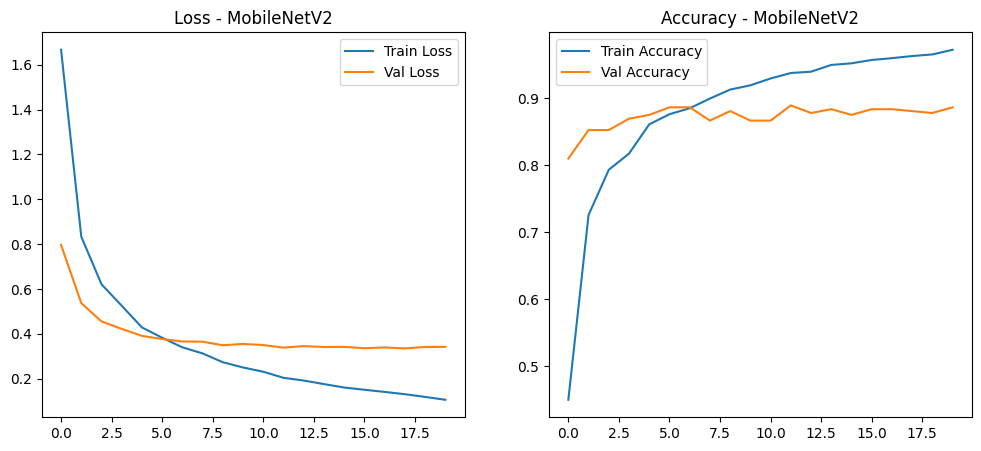

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss - MobileNetV2")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy - MobileNetV2")
plt.legend()

plt.show()


CELL 9 — EVALUASI TEST SET

In [9]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

12/12 [==============================] - 7s 557ms/step - loss: 0.5280 - accuracy: 0.8167
Test Accuracy: 0.8166666626930237


CELL 10 — CLASSIFICATION REPORT

In [10]:
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

class_labels = list(test_gen.class_indices.keys())

print(classification_report(
    y_true,
    y_pred,
    target_names=class_labels
))

12/12 [==============================] - 8s 545ms/step
                   precision    recall  f1-score   support

       abyssinian       0.92      0.74      0.82        31
           bengal       0.81      0.83      0.82        30
           birman       0.72      0.87      0.79        30
           bombay       1.00      0.90      0.95        29
british_shorthair       0.72      0.60      0.65        30
     egyptian_mau       0.89      0.86      0.88        29
       maine_coon       0.76      0.83      0.79        30
          persian       0.93      0.90      0.92        30
          ragdoll       0.63      0.63      0.63        30
     russian_blue       0.67      0.87      0.75        30
          siamese       0.96      0.77      0.86        31
           sphynx       0.91      1.00      0.95        30

         accuracy                           0.82       360
        macro avg       0.83      0.82      0.82       360
     weighted avg       0.83      0.82      0.82       360

CELL 11 — CONFUSION MATRIX

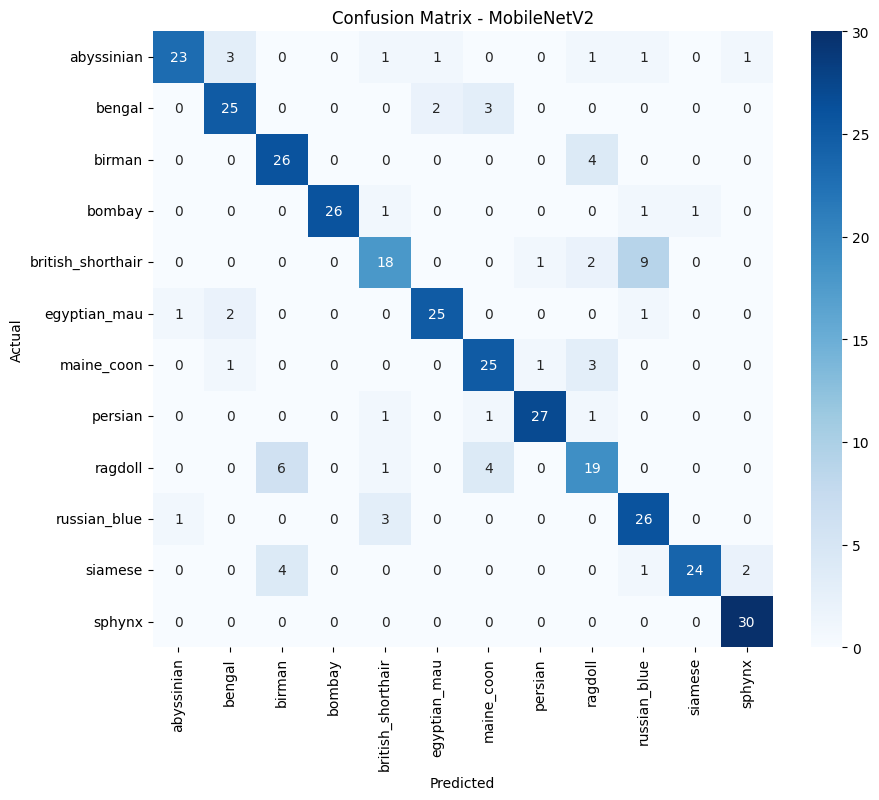

In [11]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MobileNetV2")
plt.show()

CELL 12 — SAVE FINAL MODEL (BACKUP)

In [12]:
model.save("../models/mobilenetv2_cat_breed_final.keras")
print("✅ Model MobileNetV2 berhasil disimpan")

✅ Model MobileNetV2 berhasil disimpan
